# Data preparation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, device='cpu'):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]

class TransformerModel(nn.Module):
    def __init__(self, num_features, d_model, nhead, num_layers, output_size, device, max_len=5000):
        super(TransformerModel, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model, max_len, device=device)
        self.encoder = nn.Linear(num_features, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers, batch_first=True, device=device)
        self.decoder = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.encoder(x)  # Project input to model dimension
        x = self.positional_encoding(x) # Add positional encoding
        x = self.transformer(x, x)
        x = self.decoder(x[:, -1, :])
        return x

class GRU_ForeCastModel(nn.Module):
    def __init__(self, n_features, hidden_size, n_layers, output_size, device):
        super(GRU_ForeCastModel, self).__init__()
        self.n_layers = n_layers
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device

        self.gru = nn.GRU(n_features,
                          hidden_size=hidden_size,
                          num_layers=n_layers,
                          batch_first=True)

        self.fc1 = nn.Linear(n_features * hidden_size, output_size)

    def forward(self, x, unbatched = False):
        batch_size = x.size(0)
        if unbatched:
            h0 = torch.zeros(self.n_layers, self.hidden_size).to(self.device)
        else:
            h0 = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)

        out, _ = self.gru(x, h0)
        if unbatched:
            return self.fc1(out[-1,:])
        else:
            return self.fc1(out[:,-1,:])


class CNN1D_ForeCastModel(nn.Module):
    def __init__(self, n_features, sequence_length, output_size):
        super(CNN1D_ForeCastModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * (sequence_length // 4), 50)
        self.fc2 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.permute(0,2,1) #CNN expects (batch_size, n_features, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [54]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_sine_wave(seq_length, num_sequences, future_steps):
    total_length = seq_length + future_steps  # Total length needed per sequence
    # Generate enough data for all sequences by extending the range of x
    x = np.linspace(0, 2 * np.pi * num_sequences, total_length * num_sequences)
    y = np.sin(x)
    # Extract each sequence separately ensuring they are of correct total_length
    data = np.array([y[i * total_length:(i + 1) * total_length] for i in range(num_sequences)])
    return torch.tensor(data, dtype=torch.float32).unsqueeze(-1)

# Parameters
num_features = 1  # sine wave is a single feature
d_model = 64
nhead = 4
num_layers = 3
output_size = 50
seq_length = 200
num_sequences = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate models
transformer_model = TransformerModel(num_features, d_model, nhead, num_layers, output_size, device).to(device)
gru_model = GRU_ForeCastModel(num_features, 32, 2, output_size, device).to(device)
cnn_model = CNN1D_ForeCastModel(num_features, seq_length, output_size).to(device)

models = {'Transformer': transformer_model, 'GRU': gru_model, 'CNN': cnn_model}
optimizers = {
    'Transformer': optim.Adam(transformer_model.parameters(), lr=0.001),
    'GRU': optim.Adam(gru_model.parameters(), lr=0.001),
    'CNN': optim.Adam(cnn_model.parameters(), lr=0.001)
}
loss_fn = nn.MSELoss()

# Generate data
data = generate_sine_wave(seq_length, num_sequences, output_size)
input_data = data[:, :seq_length, :]  # all data up to the last future_steps
target_data = data[:, -output_size:, :]  # the last future_steps data

cuda


In [55]:
# Training loop
num_epochs = 20
batch_size = 16

for epoch in range(num_epochs):
    permutation = torch.randperm(input_data.size()[0])
    for i in range(0, input_data.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = input_data[indices].to(device), target_data[indices].to(device)

        for name, model in models.items():
          model.train()
          optimizer = optimizers[name]
          optimizer.zero_grad()

          output = model(batch_x)
          target = batch_y[:, -output_size:, :].squeeze(2)
          loss = loss_fn(output, target)
          loss.backward()
          optimizer.step()
          if epoch%10 == 0 and i == 0:
            print(f'Epoch {epoch}, {name} Loss: {loss.item()}')

Epoch 0, Transformer Loss: 0.5951382517814636
Epoch 0, GRU Loss: 0.3921074867248535
Epoch 0, CNN Loss: 0.3942831754684448
Epoch 10, Transformer Loss: 0.00037305595469661057
Epoch 10, GRU Loss: 2.5314751837868243e-05
Epoch 10, CNN Loss: 2.655343087099027e-05


(50,)
(50,)
(50,)


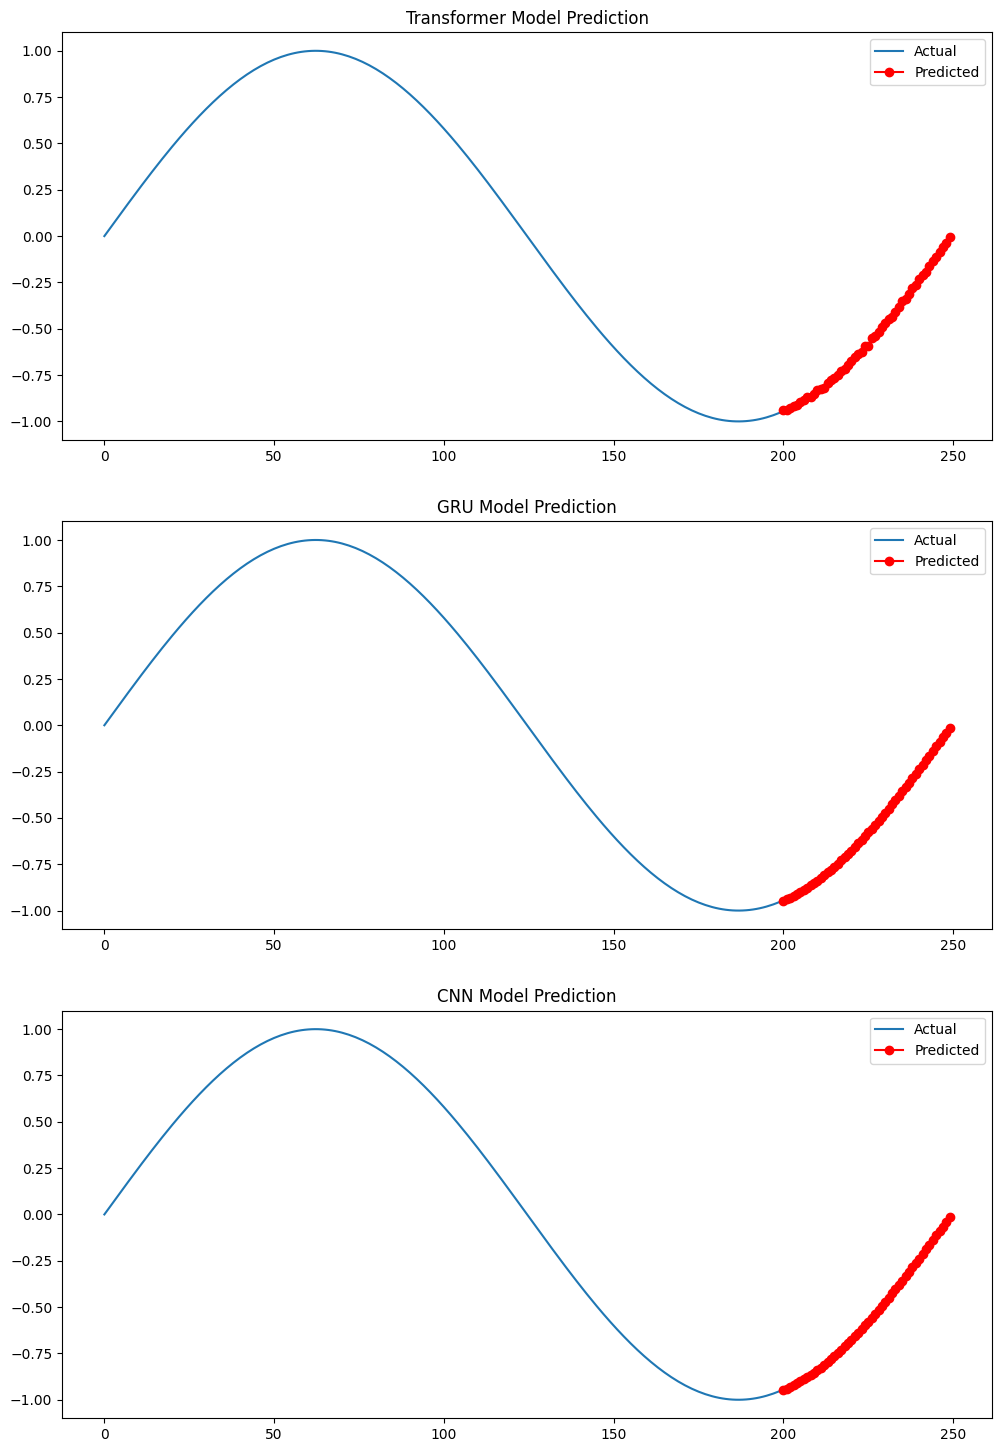

In [56]:
# Visualization
test_data = generate_sine_wave(seq_length, 1, output_size)
test_input = test_data[:, :seq_length, :].to(device)
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

for idx, (name, model) in enumerate(models.items()):
    with torch.no_grad():
        model.eval()
        predicted = model(test_input)
    predicted = predicted.cpu().numpy().squeeze()
    print(predicted.shape)
    prediction_points = np.arange(seq_length + output_size)
    axs[idx].plot(prediction_points[:seq_length],test_data[0, :seq_length, 0].numpy(), label='Actual')
    axs[idx].plot(prediction_points[seq_length:], predicted, 'ro-', label='Predicted')
    axs[idx].set_title(f'{name} Model Prediction')
    axs[idx].legend()

plt.show()